In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from lib import OCR, OCREngine, PlaneDetector
from lib.preprocessing import preprocess_paddleocr

In [3]:
plane_detector = PlaneDetector(confidence_threshold=0.5)
ocr = OCR(OCREngine.PADDLEOCR, confidence_threshold=0.5)

/Users/vojtechjindra/matyas/.venv/lib/python3.11/site-packages/paddle/utils/cpp_extension/extension_utils.py:718: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)


## Dataset run


In [4]:
from lib import Dataset, Pipeline

### Single row / video


In [5]:
dataset = Dataset("dataset.csv", drop_duplicates=False)
pipeline = Pipeline(
    plane_detector=plane_detector,
    ocr=ocr,
    processing_func=preprocess_paddleocr,
    target_fps=5,
)

In [6]:
row_id = (3358, 0)
row = dataset.loc[row_id]

dataset.loc[row_id[0]]

,Video file,Usable,Registration,Segment start,Segment end,Comment
Segment,,,,,,
0,data/IMG_3358.MOV,Yes,OK-LTY,1,4,NaN


In [7]:
ocr_res = pipeline.process_row(row)

dataset.add_results(row_id, ocr_res)

In [8]:
dataset.loc[row_id[0]]

,Video file,Usable,Registration,Segment start,Segment end,Comment,Predicted registration,Prediction confidence
Segment,,,,,,,,
0,data/IMG_3358.MOV,Yes,OK-LTY,1,4,NaN,OK-LTY,0.961749


### All rows / videos


In [79]:
dataset = Dataset("dataset.csv", drop_duplicates=False)
pipeline = Pipeline(
    plane_detector=plane_detector,
    ocr=ocr,
    processing_func=preprocess_paddleocr,
    target_fps=5,
)

In [12]:
pipeline.process_rows(dataset)

100%|██████████| 24/24 [04:01<00:00, 10.07s/it]


,,Video file,Usable,Registration,Segment start,Segment end,Comment,Predicted registration,Prediction confidence
ID,Segment,,,,,,,,
3353,0,data/IMG_3353.MOV,Yes,OK-LTY,1,3,NaN,OK-LTY,0.996377
3354,0,data/IMG_3354.MOV,Yes,OK-BIT,14,18,NaN,,0.000000
3355,0,data/IMG_3355.MOV,Yes,OK-BIT,0,3,NaN,UK-BIT,0.923114
3358,0,data/IMG_3358.MOV,Yes,OK-LTY,1,4,NaN,OK-LTY,0.961749
3359,0,data/IMG_3359.MOV,Yes,OK-BIT,19,24,NaN,OK-BIT,0.956859
3360,0,data/IMG_3360.MOV,Yes,OK-FAH,11,17,NaN,OK-FAH,0.925120
3363,0,data/IMG_3363.MOV,Yes,OK-LTY,6,13,NaN,OK-LTY,0.895824
3367,0,data/IMG_3367.MOV,Yes,OK-BIT,0,4,Úplně perfektní,OK-BIT,0.995250
3368,0,data/IMG_3368.MOV,Yes,OK-BIT,2,6,NaN,OK-BIT,0.995693


## Camera run


In [9]:
from lib import CameraSource

In [10]:
camera = CameraSource("data/IMG_3370.MOV")

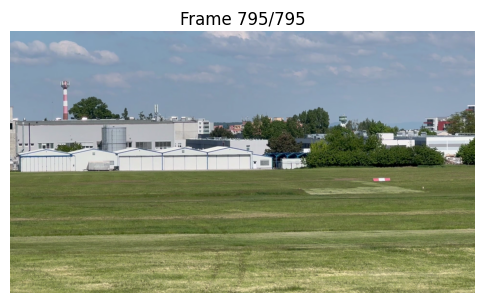

In [11]:
camera.start_stream_notebook(
    plane_detector=plane_detector,
    ocr=ocr,
    target_fps=5,
    start_frame=700,
    preprocessing_func=preprocess_paddleocr,
)